# Landslide Susceptibility Analysis
by Maria Pinto

* Study Area: Near the border of Uganda and the Democratic Republic of the Congo, encompassing parts of the Albertine Rift and Rwenzori Mountains.

This region is known for its mountainous terrain, with some parts of the Albertine Rift and the Rwenzori Mountains nearby. The green, lower-elevation areas on the DEM could represent parts of the lake or surrounding plains, while the higher-elevation areas in brown and yellow indicate the mountains. This area is part of the East African Rift System, which is a region with complex terrain, making it suitable for studying hydrology and landslide susceptibility.

## Step 1: Import Required Libraries

In [4]:
# These libraries help us manage and visualize geospatial data.
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from numpy import gradient, arctan, arctan2, degrees
from scipy.ndimage import gaussian_filter

## Step 2: Load the Digital Elevation Model (DEM)

In [7]:
# The DEM provides elevation data, which is essential for assessing the terrain.
file_path = 'N01E023.hgt'

# Open the .hgt file using rasterio
with rasterio.open(file_path) as dem:
    dem_data = dem.read(1)  # Read the first (and only) band
    dem_transform = dem.transform


In [9]:
# Display metadata to understand data structure and geospatial properties
print(dem.meta)

{'driver': 'SRTMHGT', 'dtype': 'int16', 'nodata': -32768.0, 'width': 3601, 'height': 3601, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.0002777777777777778, 0.0, 22.999861111111112,
       0.0, -0.0002777777777777778, 2.000138888888889)}


## Step 3: Visualize the DEM
We start by loading and visualizing a Digital Elevation Model (DEM), which represents ground elevations. This allows us to understand the topography of the study area, which is crucial for assessing landslide risk.

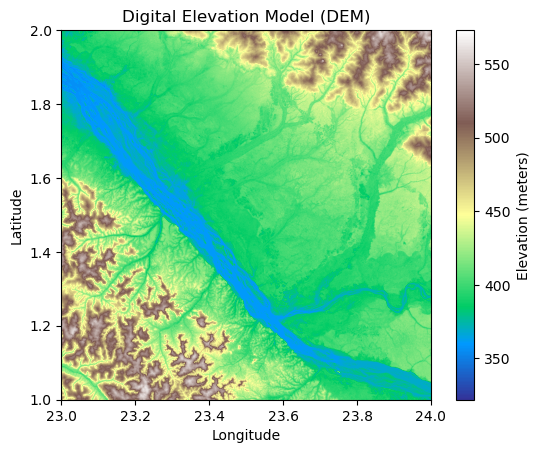

In [12]:
# This plot provides a general overview of elevation in the area of interest.plt.figure(figsize=(10, 6))
plt.imshow(dem_data, cmap='terrain', extent=(dem.bounds.left, dem.bounds.right, dem.bounds.bottom, dem.bounds.top))
plt.colorbar(label='Elevation (meters)')
plt.title("Digital Elevation Model (DEM)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


## Step 4: Calculate Slope
Here, we calculate the slope, or steepness, of each part of the terrain. This helps identify steep areas more susceptible to landslides. The slope map shows how steepness varies across the landscape, with steeper regions in darker colors.

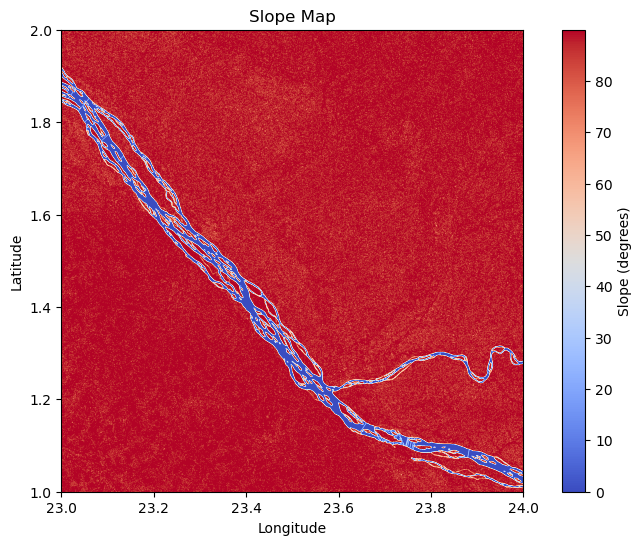

In [15]:
# Calculate the gradient in x and y directions
dy, dx = gradient(dem_data, dem_transform[0], dem_transform[4])

# Slope is the steepness of the terrain. Steeper slopes are more prone to landslides.
# Calculate slope in degrees
slope = degrees(arctan(np.sqrt(dx**2 + dy**2)))

# Plot the slope map
plt.figure(figsize=(10, 6))
plt.imshow(slope, cmap='coolwarm', extent=(dem.bounds.left, dem.bounds.right, dem.bounds.bottom, dem.bounds.top))
plt.colorbar(label="Slope (degrees)")
plt.title("Slope Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


## Step 5: Calculate Aspect
 The aspect map shows the direction each slope faces (e.g., north, east, south, or west). This directional information can help assess potential landslide areas, as slopes facing certain directions may receive more moisture or sunlight, influencing stability.

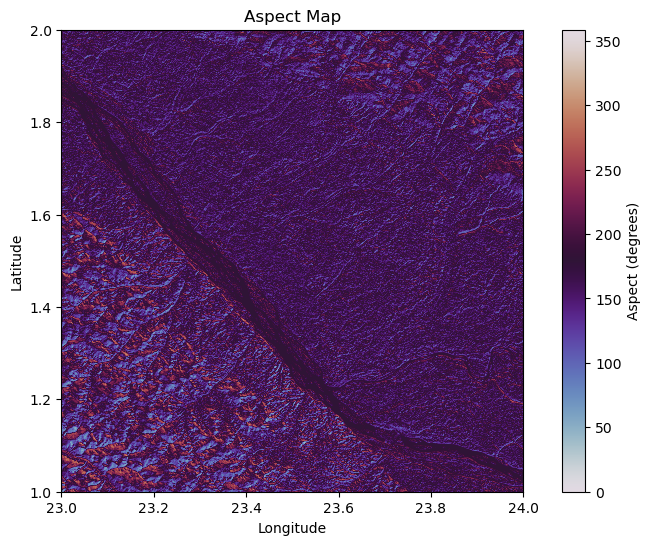

In [17]:
# Aspect is the compass direction that each slope faces, important for understanding wind, sun, and moisture effects.
aspect = (degrees(arctan2(dy, -dx)) + 180) % 360  # Adjust to 0-360 degrees /  Convert aspect to compass direction

# Plot the aspect map
plt.figure(figsize=(10, 6))
plt.imshow(aspect, cmap='twilight', extent=(dem.bounds.left, dem.bounds.right, dem.bounds.bottom, dem.bounds.top))
plt.colorbar(label="Aspect (degrees)")
plt.title("Aspect Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [18]:
print("Min elevation:", np.min(dem_data))
print("Max elevation:", np.max(dem_data))
print("Mean elevation:", np.mean(dem_data))


Min elevation: 322
Max elevation: 573
Mean elevation: 419.04270065683414


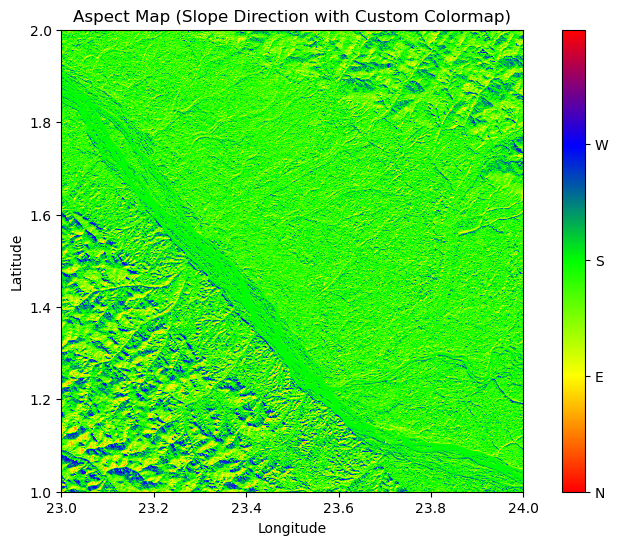

In [20]:
from matplotlib.colors import LinearSegmentedColormap

# Calculate aspect in degrees and normalize
aspect = (np.degrees(np.arctan2(dy, -dx)) + 180) % 360

# Define a custom colormap for directions
colors = [(1, 0, 0),    # Red for North (0° and 360°)
          (1, 1, 0),    # Yellow for East (90°)
          (0, 1, 0),    # Green for South (180°)
          (0, 0, 1),    # Blue for West (270°)
          (1, 0, 0)]    # Red for North (360° wraparound)

# Define a custom colormap
cmap_name = 'compass'
aspect_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

# Plot the aspect map with the custom colormap
plt.figure(figsize=(10, 6))
img = plt.imshow(aspect, cmap=aspect_cmap, extent=(dem.bounds.left, dem.bounds.right, dem.bounds.bottom, dem.bounds.top))

# Add a color bar with directional labels
cbar = plt.colorbar(img, ticks=[0, 90, 180, 270, 360])
cbar.ax.set_yticklabels(['N', 'E', 'S', 'W', 'N'])  # Add directional labels

# Set title and axis labels
plt.title("Aspect Map (Slope Direction with Custom Colormap)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()


Colors for primary compass directions:
* North (0° and 360°): Red
* East (90°): Yellow
* South (180°): Green
* West (270°): Blue

## Step 6: Smooth DEM with Gaussian Filter
Curvature shows the "shape" of the slope. Convex shapes (curved outward) are typically more susceptible to landslides. By smoothing the DEM data first, we minimize small irregularities, making curvature analysis more accurate.

In [26]:
# Smoothing reduces noise in the DEM to make it easier to identify larger patterns.
smoothed_dem = gaussian_filter(dem_data, sigma=1)


In [27]:
# Calculate gradients again with smoothed DEM for curvature calculation
dy, dx = gradient(smoothed_dem, dem_transform[0], dem_transform[4])
dyy, dyx = gradient(dy, dem_transform[0], dem_transform[4])
dxy, dxx = gradient(dx, dem_transform[0], dem_transform[4])

## Step 7: Calculate Curvature
Curvature shows the "shape" of the slope. Convex shapes (curved outward) are typically more susceptible to landslides. By smoothing the DEM data first, we minimize small irregularities, making curvature analysis more accurate.

In [31]:
# Curvature indicates the shape of the slope. Convex areas (positive curvature) are more likely to fail in landslides.
curvature = dxx + dyy

In [34]:
# Clip curvature values for better visualization (optional)
curvature = np.clip(curvature, -100, 100)  # Adjust the clipping range if needed


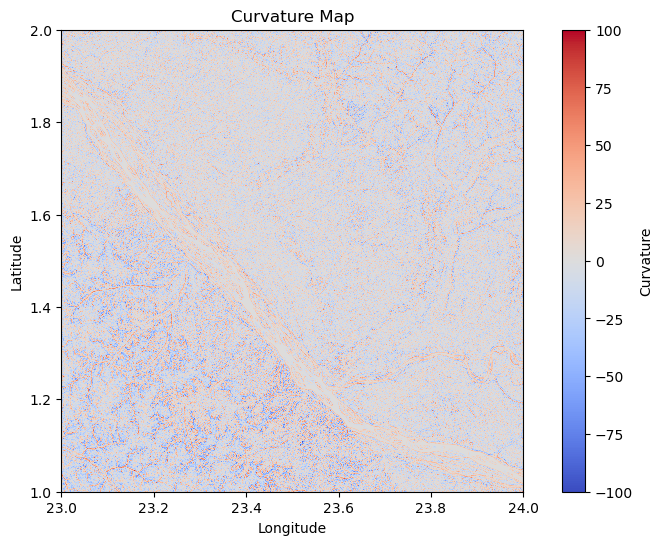

In [36]:
# Plot the Curvature Map
plt.figure(figsize=(10, 6))
plt.imshow(curvature, cmap='coolwarm', extent=(dem.bounds.left, dem.bounds.right, dem.bounds.bottom, dem.bounds.top))
plt.colorbar(label="Curvature")
plt.title("Curvature Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [37]:
print("Curvature Min:", np.min(curvature))
print("Curvature Max:", np.max(curvature))


Curvature Min: -100.0
Curvature Max: 100.0


In [40]:
print("DEM transform:", dem_transform)


DEM transform: | 0.00, 0.00, 23.00|
| 0.00,-0.00, 2.00|
| 0.00, 0.00, 1.00|


## Step 8: Define Susceptibility Thresholds
By applying thresholds for slope and curvature, we classify areas likely to be at risk for landslides. This susceptibility map highlights these risk zones in red, allowing us to pinpoint locations that need closer monitoring or preventive action.

In [43]:
# These thresholds define conditions for landslide-prone areas.
slope_threshold = 10  # Steep slopes above 10 degrees are considered riskier
curvature_threshold = 0  # Positive curvature (convex) is considered riskier

## Step 9: Apply Thresholds for Landslide Susceptibility

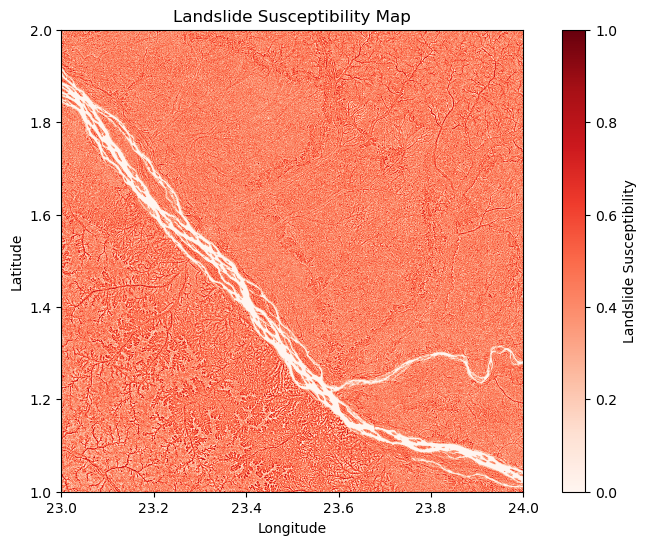

In [46]:
# Areas meeting both conditions are flagged as susceptible to landslides.
susceptibility = (slope > slope_threshold) & (curvature > curvature_threshold)

# Plot Landslide Susceptibility Map
plt.figure(figsize=(10, 6))
plt.imshow(susceptibility, cmap='Reds', extent=(dem.bounds.left, dem.bounds.right, dem.bounds.bottom, dem.bounds.top))
plt.colorbar(label="Landslide Susceptibility")
plt.title("Landslide Susceptibility Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()



## Step 10: 3D Visualization of Terrain and Susceptibility
The 3D visualization provides an integrated view of terrain elevation and landslide susceptibility. The red overlay shows where the terrain is most vulnerable, helping stakeholders visually grasp the spatial relationship between topography and risk areas.

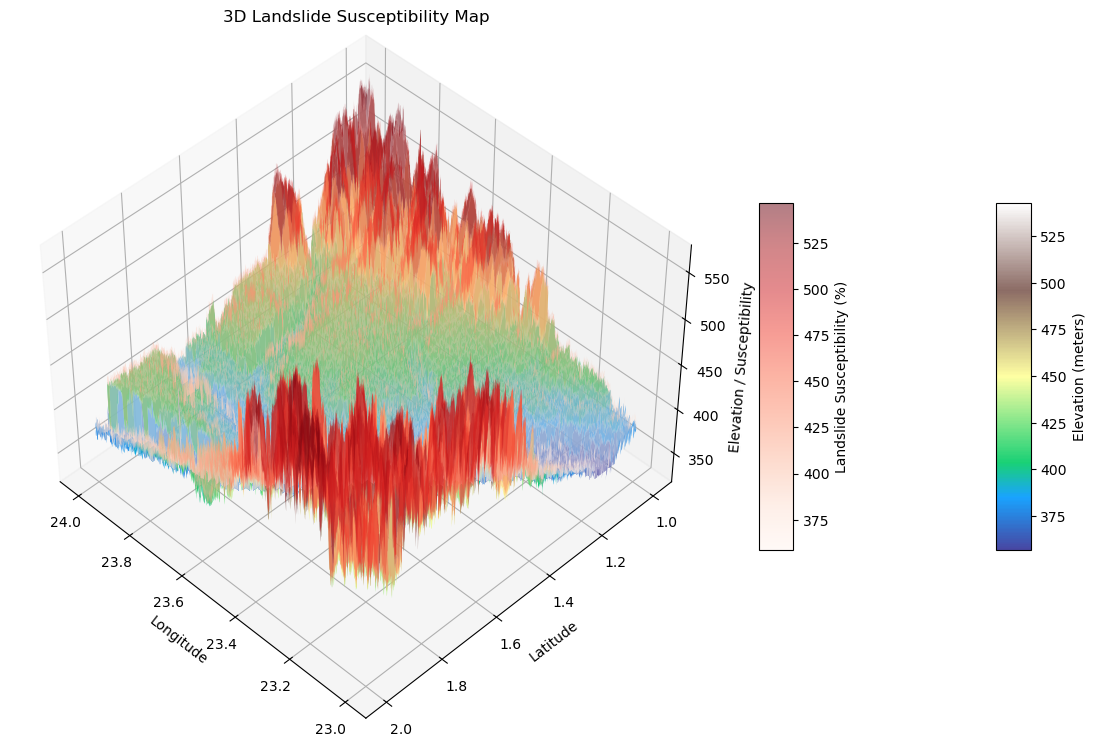

In [49]:
# This 3D view overlays the susceptibility map on the terrain to give a comprehensive visual of risk zones.
x = np.linspace(dem.bounds.left, dem.bounds.right, dem_data.shape[1])
y = np.linspace(dem.bounds.bottom, dem.bounds.top, dem_data.shape[0])
x, y = np.meshgrid(x, y)
z = dem_data  # Elevation data

# Set up 3D figure
fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot terrain surface
surf = ax.plot_surface(x, y, z, cmap='terrain', edgecolor='none', alpha=0.9)

# Overlay susceptibility on terrain
susceptibility_layer = ax.plot_surface(x, y, z + susceptibility * 10, cmap='Reds', edgecolor='none', alpha=0.5)

# Add color bars for elevation and susceptibility
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Elevation (meters)')
cbar_susceptibility = fig.colorbar(susceptibility_layer, ax=ax, shrink=0.5, aspect=10)
cbar_susceptibility.set_label('Landslide Susceptibility (%)')

# Set labels and adjust view angle for better clarity
ax.set_title("3D Landslide Susceptibility Map")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Elevation / Susceptibility")
ax.view_init(elev=45, azim=135)
plt.show()